# <center> Building and Training a UNet Model

### About the Dataset

This dataset contains 9766 realistic renders of lunar landscapes and their masks (segmented into three classes: sky, small rocks, bigger rocks). Additionally, a csv file of bounding boxes and cleaned masks of ground truths are provided.

An interesting feature of this dataset is that the images are synthetic; they were created using Planetside Software's Terragen. This isn't too obvious immediately as the renderings are highly realistic but it does make more sense after taking into account the scarcity of space imagery data.

Acknowledgment: Romain Pessia and Genya Ishigami of the Space Robotics Group, Keio University, Japan. You can find the dataset https://www.kaggle.com/romainpessia/artificial-lunar-rocky-landscape-dataset

### Reminder to turn on your GPU accelerator, from right hand side of your kaggle notebook, under Settings.

### Importing libraries



In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 

from tqdm import tqdm
import glob
from sklearn.model_selection import train_test_split

## Installing segmentation_models module

Make sure to turn your internet on from kaggle settings on the right hand side. If you don't see the Internet option in Settings, verify your kaggle profile by updating you phone number. 

### you'll know more about segmentation_models at the end of this lecture and in the next lecture. In this lecture we'll only use segmentation_models for iou_score. 

In [2]:
!pip install segmentation_models

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 731.9 kB/s eta 0:00:00:--:--


In [3]:
import segmentation_models as sm

os.environ["SM_FRAMEWORK"] = "tf.keras"
sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


## Data Preprocessing Pipeline

In [15]:
'''
Here load_data function is called. This will load the dataset paths and 
split it into X_train, X_test, y_train, y_test '''

img_dir = '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/render'
mask_dir = '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/clean'


# let's get the list of image paths and mask paths in sorted order from the given directory respectively
images = [os.path.join(img_dir, x) for x in sorted(os.listdir(img_dir))]
masks = [os.path.join(mask_dir, x) for x in sorted(os.listdir(mask_dir))]

In [16]:
# let's get top 5 images and masks from the lists
images[:5], masks[:5]

(['/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/render/render0001.png',
  '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/render/render0002.png',
  '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/render/render0003.png',
  '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/render/render0004.png',
  '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/render/render0005.png'],
 ['/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0001.png',
  '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0002.png',
  '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0003.png',
  '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0004.png',
  '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0005.png'])

## For this session, we will just use first 2000 images and masks as our dataset

In [17]:
images = images[:2000]
masks = masks[:2000]

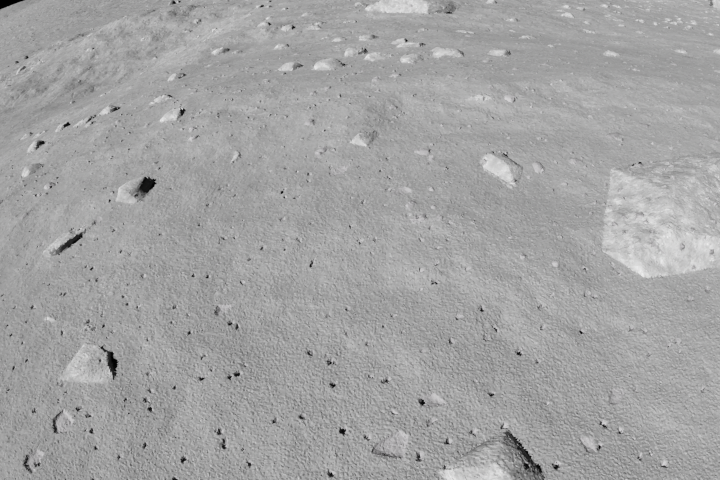

In [18]:
sample_img = Image.open(images[1])
sample_img

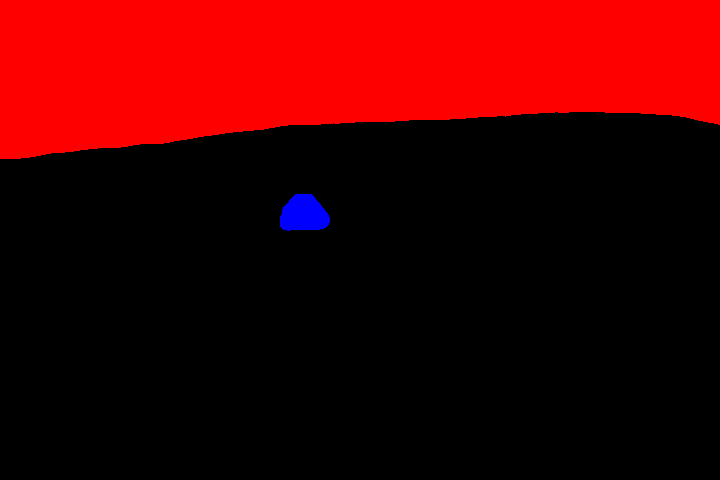

In [19]:
sample_mask = Image.open(masks[0])
sample_mask

In [20]:
sample_img.size

(720, 480)

### Originally, our images size is (720, 480) but we will reduce the size for better and faster processing. Since we are focusing on the clean masks so it will not effect much. 

### Ground masks are more detailed and have so much noise. We'll keep things easy for our lecture. However, feel free to use ground masks and play around to explore more. 

In [21]:
# we will use this shape of data for our model
H = 256 # height of image
W = 256 # width of image


# for images and labels, to store our dataset
X_img = []
y_mask = []

# here we have our loop to read, process and store our images X_img, and y_mask variables
for x, y in tqdm(zip(images, masks)):
    # reading images
    img = cv2.imread(x, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (W, H))
    img = img / 255.0
    img = img.astype(np.float32) # if pixel values are less than 1, then it is important that the values have float datatype
    
    # reading masks
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))
    mask = mask.astype(np.int32)  # if pixel values are between 1 and 255, then it is important that the values have integer datatype
    
    # storing images and masks
    X_img.append(img)
    y_mask.append(mask)


2000it [01:27, 22.78it/s]


In [22]:
X_img = np.array(X_img)
y_mask = np.array(y_mask)

# 1600 datapoints as training dataset and 400 for validation dataset 
X_train = X_img[:1600]
X_valid = X_img[1600:]

y_train = y_mask[:1600]
y_valid = y_mask[1600:]


In [23]:
X_train.shape
# number of images, height, width, channels

(1600, 256, 256, 3)

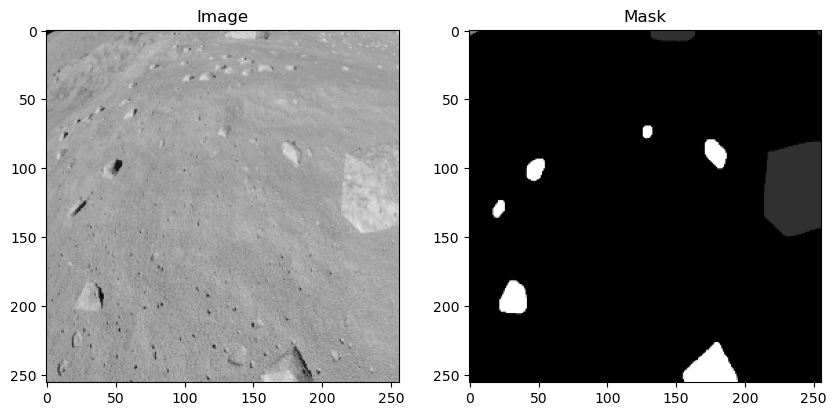

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 10))

ax1.set_title('Image')
ax2.set_title('Mask')

ax1.imshow(X_train[1])
ax2.imshow(y_train[1], cmap = 'gray')

plt.show()

Check this article to know more about how to build optimized data pipeline using tf
https://www.tensorflow.org/guide/data_performance

# Data Pipeline

### One hot encoding

![](https://i.imgur.com/mtimFxh.png)

#### Similarly, we'll one hot encode our labels to 4 different channels for four classes

In [25]:
batch_size = 4
num_classes = 4 

'''Here the from_tensor_slices function is called to make dataset objects of our training and validation sets'''
# calling tf_dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, tf.one_hot(y_train, num_classes, dtype=tf.int32)))

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, tf.one_hot(y_valid, num_classes, dtype=tf.int32)))


2023-02-17 10:22:20.548347: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-02-17 10:22:20.548409: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


Read more about prefetching and AUTOTUNE here: https://www.tensorflow.org/guide/data_performance#optimize_performance

## Naive Approach
![](https://www.tensorflow.org/guide/images/data_performance/naive.svg)


## After prefetching

![](https://www.tensorflow.org/guide/images/data_performance/prefetched.svg)

In [26]:
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [27]:
sample = iter(valid_dataset)
data = next(sample)
data[0].shape
# batch size, height, width, channels

TensorShape([4, 256, 256, 3])

In [28]:
data[1].shape
# batch size, height, width, channels/classes

TensorShape([4, 256, 256, 4])

## Creating U-net Architecture

In [29]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

'''conv_block it is used to create one block with two convolution layer 
followed by BatchNormalization and activation function relu. 
If the pooling is required then Maxpool2D is applied and return it else not.'''
# function to create convolution block
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

'''build_unet it is used to create the U-net architecture.'''
# function to build U-net
def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    # Reference for UpSampling2D: https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D
    # it simply repeats the rows and columns of the data by size[0] and size[1] respectively in nearest interpolation
    # check below in the below cell, the difference between bilinear and nearest interpolation
    u1 = UpSampling2D(size = (2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

In [30]:
input_shape = (1, 3, 2, 1)
x = np.arange(np.prod(input_shape)).reshape(input_shape)
print(x)

b = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation = "bilinear")(x)
print(b)

n = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation = "nearest")(x)
print(n)


[[[[0]
   [1]]

  [[2]
   [3]]

  [[4]
   [5]]]]
tf.Tensor(
[[[[0.  ]
   [0.25]
   [0.75]
   [1.  ]]

  [[0.5 ]
   [0.75]
   [1.25]
   [1.5 ]]

  [[1.5 ]
   [1.75]
   [2.25]
   [2.5 ]]

  [[2.5 ]
   [2.75]
   [3.25]
   [3.5 ]]

  [[3.5 ]
   [3.75]
   [4.25]
   [4.5 ]]

  [[4.  ]
   [4.25]
   [4.75]
   [5.  ]]]], shape=(1, 6, 4, 1), dtype=float32)
tf.Tensor(
[[[[0]
   [0]
   [1]
   [1]]

  [[0]
   [0]
   [1]
   [1]]

  [[2]
   [2]
   [3]
   [3]]

  [[2]
   [2]
   [3]
   [3]]

  [[4]
   [4]
   [5]
   [5]]

  [[4]
   [4]
   [5]
   [5]]]], shape=(1, 6, 4, 1), dtype=int64)


**For Contracting Path:** the **conv_block** function is called four time which will create four block with pooling (pool = True). The process is repeated 3 more times.

**For Bridge:** the **conv_block** function is called one time without pooling (pool=False).

**For Expansive Path: UpSampling2D** is used to expands the size of images. This expanded  image is concatenated with the corresponding image from the contracting path, The reason here is to combine the information from the previous layers in order to get a more precise prediction. And now **conv_block** function is called without pooling (pool=False). The process is repeated 3 more times.

The last step is to reshape the image to satisfy our prediction requirements. The last layer is a convolution layer with 1 filter of size 1x1.

In [31]:
# calling build_unet function
model = build_unet((256, 256, 3), 4)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Load model and compile

In [32]:
# importing libraries
from segmentation_models.metrics import iou_score

""" Hyperparameters """
lr = 1e-4
epochs = 5

"""Model"""
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(lr), 
              metrics=[iou_score])


train_steps = len(X_train)//batch_size
valid_steps = len(X_valid)//batch_size

## Train model

In [33]:
'''model.fit is used to train the model'''
model_history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs
    )

Epoch 1/5
400/400 [==============================] - 763s 2s/step - loss: 0.3618 - iou_score: 0.1438 - val_loss: 0.2356 - val_iou_score: 0.1523
Epoch 2/5
400/400 [==============================] - 760s 2s/step - loss: 0.2063 - iou_score: 0.1693 - val_loss: 0.1714 - val_iou_score: 0.1748
Epoch 3/5
400/400 [==============================] - 759s 2s/step - loss: 0.1388 - iou_score: 0.1820 - val_loss: 0.1092 - val_iou_score: 0.1883
Epoch 4/5
400/400 [==============================] - 751s 2s/step - loss: 0.0973 - iou_score: 0.1902 - val_loss: 0.0845 - val_iou_score: 0.1905
Epoch 5/5
400/400 [==============================] - 750s 2s/step - loss: 0.0782 - iou_score: 0.1915 - val_loss: 0.0674 - val_iou_score: 0.1939


## Predict from model

In [34]:
# function to predict result 
def predict_image(img_path, mask_path, model):
    H = 256
    W = 256
    num_classes = 4

    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (W, H))
    img = img / 255.0
    img = img.astype(np.float32)

    ## Read mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))   ## (256, 256)
    mask = np.expand_dims(mask, axis=-1) ## (256, 256, 1)
    mask = mask * (255/num_classes)
    mask = mask.astype(np.int32)
    mask = np.concatenate([mask, mask, mask], axis=2)

    ## Prediction
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = pred_mask * (255/num_classes)
    pred_mask = pred_mask.astype(np.int32)
    pred_mask = np.concatenate([pred_mask, pred_mask, pred_mask], axis=2)

    return img, mask, pred_mask

In [35]:
# function to display result
def display(display_list):
  plt.figure(figsize=(12, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask', 'Mask On Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

1/1 [==============================] - 1s 586ms/step


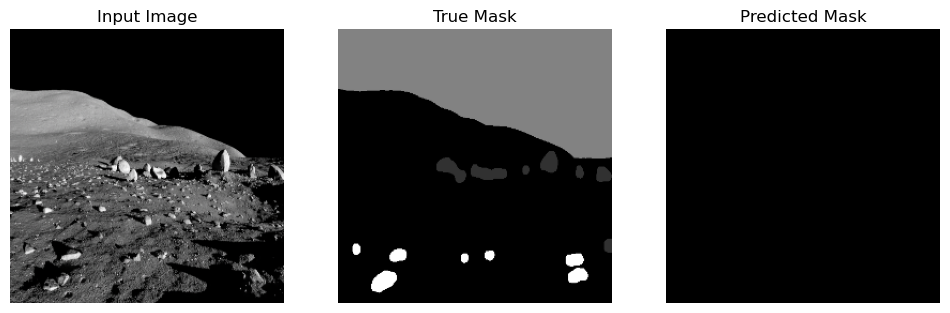

In [36]:
img_path = '../input/artificial-lunar-rocky-landscape-dataset/images/render/render0041.png'
mask_path = '../input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0041.png'

img, mask, pred_mask = predict_image(img_path, mask_path, model)

display([img, mask, pred_mask])

## segmentation_model

segmentation_models is a python library with Neural Networks for Image Segmentation based on Keras and TensorFlow.

The main features of this library are:

* High level API (just two lines of code to create model for segmentation)
* 4 models architectures for binary and multi-class image segmentation (including legendary Unet)
* 25 available backbones for each architecture
* All backbones have pre-trained weights for faster and better convergence
* Helpful segmentation losses (Jaccard, Dice, Focal) and metrics (IoU, F-score)

Learn more: https://segmentation-models.readthedocs.io/en/latest/tutorial.html

## A practical note: different backbones in modern U-Nets

So far, you have looked at how the U-Net architecture was implemented in the original work by Ronneberger et al. Over the years, many people have experienced with different setups for U-Nets, including pretraining on e.g. ImageNet and then finetuning to their specific image segmentation tasks.

This means that today, you will likely use a U-Net that no longer utilizes the original architecture as proposed above - but it's still a good starting point, because the contractive path, expansive path and the skip connections remain the same.

**Common backbones for U-Net architectures these days are ResNet, ResNeXt, EfficientNet and DenseNet architectures. Often, these have been pretrained on the ImageNet dataset, so that many common features have already been learned. By using these backbone U-Nets, initialized with pretrained weights, it's likely that you can reach convergence on your segmentation problem much faster.**

That's it! You have now a high-level understanding of U-Net and its components sunglasses.

## In the next session, we will learn how you can use segmentation_models using Transfer learning to use UNet architecture with different pretrained models as backbone.

## In next week, we will learn about different techniques to improve the accuracy of our model. 